In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
import torch.utils.data as dt
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from PIL import Image

In [2]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [3]:
def save_model(network, path='state'):
    with open(path, 'w') as f:
        torch.save(network, path)

def load_model(path):
    return torch.load(path)

def save_state(network, path='state'):
    torch.save(network.state_dict(), path)
    
def load_state(class_ , path):
    network = class_()
    network.load_state_dict(torch.load(path))
    return network

In [4]:
def class_max(tensor):
    _, _, height, width = tensor.shape
    output = torch.zeros(1, height, width)
    for row in range(height):
        for col in range(width):
            if tensor[0, 0, row, col] > tensor[0, 1, row, col]:
                output[0, row, col] = 1
            else:
                output[0, row, col] = 0
    return output

def separate_classes(tensor):
    ones = torch.ones(tensor.shape)
    inverted = ones - tensor
    return torch.cat((tensor, inverted), dim = 1)

In [5]:
class CarvanaDataset(dt.Dataset):
    """
        Carvana features dataset.  Override torch Dataset class to implements reading from h5 files
    """

    def __init__(self, data_path, mask_path, input_size=224):
        """
        Args:
            data_path (string): Path to the images data files.
            mask_path (string): Path were images masks are placed
        """
        self.files = os.listdir(data_path)
        self.files.sort()
        self.mask_files = os.listdir(mask_path)
        self.mask_files.sort()
        self.data_path = data_path
        self.mask_path = mask_path
        assert (len(self.files) == len(self.mask_files))
        self.input_size = input_size

        self.preprocess = transforms.Compose([
            transforms.Scale((input_size, input_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)

    def pil_load(self, path, is_input=True):
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                return img.convert('RGB')

    def pil_save(self, t, img_path):
        a = to_img(t)
        a.save(img_path, 'PNG')

    def __getitem__(self, idx):
        f_name = os.path.join(self.data_path, self.files[idx])
        m_name = os.path.join(self.mask_path, self.mask_files[idx])

        if os.path.exists(f_name) is False:
            raise Exception('Missing file with name ' + f_name + ' in dataset')

        input_ = self.pil_load(f_name)
        target = self.pil_load(m_name, False)

        input_ = self.preprocess(input_)
        target = self.preprocess(target)
        target = torch.sum(target, dim=0).unsqueeze(0)
        target[torch.gt(target, 0)] = 1

        return input_, target


In [6]:
def CBR_block(in_planes, out_planes, upsample=False, kernel=3, stride=1, padding=1, output_padding=0):
    if upsample:
        conv = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=kernel, stride=stride,
                                  padding=padding, output_padding=output_padding)
    else:
        conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel, stride=stride,
                        padding=padding)

    return nn.Sequential(conv,
                         nn.BatchNorm2d(num_features=out_planes),
                         nn.ReLU(True))


# input size Bx3x224x224
class SegmenterModel(nn.Module):
    def __init__(self, in_size=3):
        super(SegmenterModel, self).__init__()
        # Downsample
        self.downsize = CBR_block(3, 16, kernel=3, stride=2)
        self.downsample = nn.Sequential(CBR_block(16, 16),
                                        CBR_block(16, 16),
                                        CBR_block(16, 32, kernel=3, stride=2),
                                        CBR_block(32, 32),
                                        CBR_block(32, 32),
                                        CBR_block(32, 64, kernel=3, stride=2))
        # Upsample
        self.upsample = nn.Sequential(CBR_block(64, 32, upsample=True, kernel=3, stride=2, output_padding=1),
                                      CBR_block(32, 32),
                                      CBR_block(32, 32),
                                      CBR_block(32, 16, upsample=True, kernel=3, stride=2, output_padding=1),
                                      CBR_block(16, 16),
                                      CBR_block(16, 16))
        self.upsize = CBR_block(16, 2, upsample = True, kernel=3, stride=2, output_padding=1)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.downsize(x)
        x = self.downsample(x)
        x = self.upsample(x)
        x = self.upsize(x)
        return self.softmax(x)

In [7]:
n_epoch = 40
log = './log/'
train = './data/train/'
train_masks = './data/train_masks/'
test = './data/test/'
test_masks = './data/test_masks'

ds = CarvanaDataset(train, train_masks)
ds_test = CarvanaDataset(test, test_masks)
dl = dt.DataLoader(ds, shuffle=True, num_workers=4, batch_size=32)
dl_test = dt.DataLoader(ds_test, shuffle=False, num_workers=1, batch_size=32)

/home/v.svinin/anaconda3/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [8]:
full_loss_train = []
full_loss_test = []

def train_network(net):
    net.cuda()
    criterion = nn.BCELoss().cuda()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay=0.0001, momentum=0.9)

    for epoch in tqdm.tqdm_notebook(range(0, n_epoch)):
            
        epoch_loss = 0
        net.train(True)
        for iter, (x, x_mask) in enumerate(dl):
            x = Variable(x).cuda()
            x_mask = separate_classes(x_mask)
            x_mask = Variable(x_mask).cuda()
            
            x_mask_guess = net(x)
            loss = criterion(x_mask_guess, x_mask)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / float(len(ds))
        full_loss_train.append(epoch_loss)

        test_loss = 0
        net.train(False)

        for iter, (x, x_mask) in enumerate(dl_test):
            x = Variable(x).cuda()
            x_mask = separate_classes(x_mask)
            x_mask = Variable(x_mask).cuda()
        
            x_mask_guess = net(x)
            loss = criterion(x_mask_guess, x_mask)
            test_loss += loss.item()
        
        test_loss = test_loss / float(len(ds_test))
        full_loss_test.append(test_loss)
        print('Epoch: %d | Train loss: %f, Test loss: %f' % (epoch, epoch_loss, test_loss))

In [9]:
net = SegmenterModel()
%time train_network(net)

Epoch: 0 | Train loss: 0.016062, Test loss: 0.032065
Epoch: 1 | Train loss: 0.014496, Test loss: 0.020773
Epoch: 2 | Train loss: 0.013439, Test loss: 0.016898
Epoch: 3 | Train loss: 0.012621, Test loss: 0.014459
Epoch: 4 | Train loss: 0.011702, Test loss: 0.017002
Epoch: 5 | Train loss: 0.008940, Test loss: 0.013561
Epoch: 6 | Train loss: 0.006482, Test loss: 0.014521
Epoch: 7 | Train loss: 0.006026, Test loss: 0.006320
Epoch: 8 | Train loss: 0.005320, Test loss: 0.006152
Epoch: 9 | Train loss: 0.004812, Test loss: 0.007036
Epoch: 10 | Train loss: 0.004492, Test loss: 0.004932
Epoch: 11 | Train loss: 0.004356, Test loss: 0.007020
Epoch: 12 | Train loss: 0.004176, Test loss: 0.004818
Epoch: 13 | Train loss: 0.003969, Test loss: 0.005583
Epoch: 14 | Train loss: 0.003977, Test loss: 0.004390
Epoch: 15 | Train loss: 0.003759, Test loss: 0.005207
Epoch: 16 | Train loss: 0.003592, Test loss: 0.003578
Epoch: 17 | Train loss: 0.003456, Test loss: 0.003484
Epoch: 18 | Train loss: 0.003253, Test

In [9]:
net = load_model('./models/model_tr_v1_40iter')

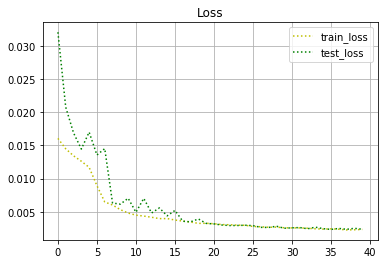

In [11]:
import matplotlib.pyplot as plt
plt.grid(True)
plt.title('Loss')
plt.plot(full_loss_train, 'y:', label = 'train_loss')
plt.plot(full_loss_test, 'g:', label = 'test_loss')
plt.legend()

### Результаты работы

In [11]:
def tensor_to_img(tensor):
    return ToPILImage()(tensor)

def display(tensors, figsize=(6, 16)):
    plt.figure(figsize=figsize)
    for n, tensor in enumerate(tensors):
        img = tensor_to_img(tensor)
        sp = plt.subplot(1, len(tensors), n+1)
        sp.imshow(img)
    plt.show()

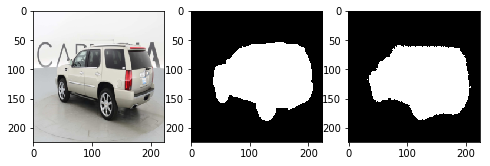

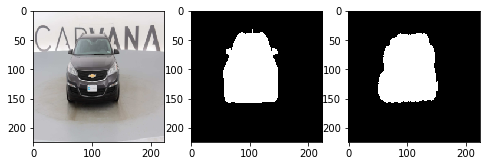

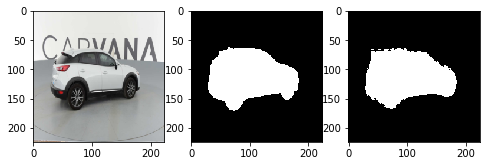

In [16]:
from random import randint
for _ in range(3):
    image, image_mask = ds_test[randint(0, 507)]

    input_ = Variable(image.unsqueeze_(0)).cuda()
    output = net(input_)

    image_mask_guess = class_max(output)
    display((image.squeeze_(0), image_mask, image_mask_guess), figsize=(8,24))